# Preparação do ambiente e consultas teste

In [55]:
import pandas as pd
import seaborn as sb
import matplotlib.pylab as plt
import cufflinks as cf

low_memory=False
%matplotlib inline
pd.options.display.max_columns = 80
pd.options.display.max_rows = 90
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Importação dos Arquivos CSV

In [58]:
gastos2017 = pd.read_csv('Ano-2017.csv', low_memory=False,delimiter=';', encoding='UTF-8', decimal=',')
gastos2014 = pd.read_csv('Ano-2014.csv', low_memory=False,delimiter=';', encoding='UTF-8', decimal=',')
gastos2013 = pd.read_csv('Ano-2013.csv', low_memory=False,delimiter=';', encoding='UTF-8', decimal=',')
proposicoes2017 = pd.read_csv('proposicoesAutores-2017.csv', low_memory=False,delimiter=';', encoding='UTF-8', decimal=',')
proposicoes2014 = pd.read_csv('proposicoesAutores-2014.csv', low_memory=False,delimiter=';', encoding='UTF-8', decimal=',')
proposicoes2013 = pd.read_csv('proposicoesAutores-2013.csv', low_memory=False,delimiter=';', encoding='UTF-8', decimal=',')

In [59]:
gastos2017.rename(columns={'txNomeParlamentar': 'NOME',
                  }, inplace=True)
gastos2014.rename(columns={'txNomeParlamentar': 'NOME',
                  }, inplace=True)
gastos2013.rename(columns={'txNomeParlamentar': 'NOME',
                  }, inplace=True)

## Teste de controle de Gasto de um Deputado

In [60]:
df = gastos2017.loc[gastos2017['NOME'] == 'TIRIRICA']
df['vlrLiquido'].sum()

87706.56000000001

# Funções Utilizadas no Projeto

In [61]:
# Recebe o Dataframe de gastos e monta um dataframe contendo apenas o Nome do Deputado e o total de gastos
def createDataframeGastosDeputado(df):
    a = df.groupby(
        by=['NOME'])['vlrLiquido'].sum()
    gastosDeputado = pd.DataFrame({'NOME': a.index, 'GASTOS':a.values})
    return gastosDeputado

#Recebe o DataFrame de proposições e monta um dataframe contendo apenas o nome do deputado e o número total de proposições
def createDataframeProposicoesDeputado(df):
    df = df['nomeAutor'].str.upper()
    df = pd.DataFrame(df)
    series = df.groupby(['nomeAutor']).size()
    proposicoesautor = pd.DataFrame({'NOME': series.index, 'PROPOSIÇÕES':series.values})
    return proposicoesautor

#Recebe o DataFrame de gastos e o ano e monta um Dataframe com os gastos de cada descrição em cada mês
def create_TableDescription(df,ano):
    dfmeses = pd.DataFrame(df[df['numMes'] == 1].groupby(by=['txtDescricao'])['vlrLiquido'].sum())
    dfmeses['mes'] = 1
    dfmeses.head()
    for x in range(11):
        dfaux = pd.DataFrame(df[df['numMes'] == x+2].groupby(by=['txtDescricao'])['vlrLiquido'].sum())
        dfaux['mes'] = x+2
        frames=[dfmeses,dfaux]
        dfmeses = pd.concat(frames,sort=False)

    dfmeses = pd.DataFrame({'txtDescricao': dfmeses.index, 'vlrLiquido':dfmeses['vlrLiquido'], 'numMes': dfmeses['mes']})
    dfmeses.reset_index(drop = True, inplace = True)
    dfmeses['ano'] = ano
    return dfmeses

#Recebe o DataFrame proveniente da função createDataframeGastosDeputado e monta um gráfico baseado em faixas de gasto de 100000 em 100000
def montarGraficoFaixadeGastos(gastosDeputado):
    faixa1 = gastosDeputado[gastosDeputado['GASTOS'] < 100000]['NOME'].count()
    faixa2 = gastosDeputado[(gastosDeputado['GASTOS'] < 200000) & (gastosDeputado['GASTOS']>= 100000)]['NOME'].count()
    faixa3 = gastosDeputado[(gastosDeputado['GASTOS'] < 300000) & (gastosDeputado['GASTOS']>= 200000)]['NOME'].count()
    faixa4 = gastosDeputado[(gastosDeputado['GASTOS'] < 400000) & (gastosDeputado['GASTOS']>= 300000)]['NOME'].count()
    faixa5 = gastosDeputado[(gastosDeputado['GASTOS'] >= 400000)]['NOME'].count()
    data = {'Faixa de Gasto':['<100000', 'Entre 100000 e 200000','Entre 200000 e 300000','Entre 300000 e 400000','>400000'],'Número de entradas':[faixa1,faixa2,faixa3,faixa4,faixa5]}
    faixadegastos = pd.DataFrame(data = data)
    faixadegastos['Número de entradas'].plot(labels = ['','','','',''],kind='pie',autopct='%.2f', figsize= (9,9),title = 'Gráfico com porcentagem por faixa de gastos')#.get_yaxis().set_visible(False)
    plt.legend(faixadegastos['Faixa de Gasto'])
    plt.axis('equal')
    plt.axis('off')
    plt.show()

#Recebe os DataFrames provenientes de createDataframeGastosDeputado e createDataframeProposicoesDeputado e calcula a média custo/proposição da câmara dos deputados
def calcularMediaProposicao(gastos,proposicoes):
    gastos = gastos['vlrLiquido'].sum()/len(proposicoes)
    print('{0:.2f}'.format(gastos) , "reais por proposição na câmara dos deputados")
    
#Recebe os Dataframes provenientes de createDataframeGastosDeputado e createDataframeProposicoesDeputado e um boolean (True = Deputados que menos gastaram, False= Mais gastaram) e imprime um gráfico com os 15 Deputados e seus respectivos gastos
def graficoDeputadosGastosProposicao(gastosDeputado, proposicoesautor,asc):
    result = pd.merge(proposicoesautor, gastosDeputado, on='NOME', how='inner')
    media = result['GASTOS']/result['PROPOSIÇÕES']
    result['MEDIA'] = media
    a = result.sort_values(['MEDIA'], ascending = asc).head(15)
    if asc:
        a = a.sort_values(['MEDIA'], ascending = False)
    plt.barh(a['NOME'], a['MEDIA'])
    plt.grid()
    plt.show()


## Execução das Funções para os DataFrames

In [62]:
gastosDeputado2017 = createDataframeGastosDeputado(gastos2017)
gastosDeputado2014 = createDataframeGastosDeputado(gastos2014)
gastosDeputado2013 = createDataframeGastosDeputado(gastos2013)
dfmeses2017 = create_TableDescription(gastos2017,2017)
dfmeses2014 = create_TableDescription(gastos2014,2014)
dfmeses2013 = create_TableDescription(gastos2013,2013)
proposicoesautor2017 = createDataframeProposicoesDeputado(proposicoes2017)
proposicoesautor2014 = createDataframeProposicoesDeputado(proposicoes2014)
proposicoesautor2013 = createDataframeProposicoesDeputado(proposicoes2013)

# Análise dos Gastos dos Deputados

## Gastos por Deputado

In [63]:
gastosDeputado2017.sort_values(by = ['GASTOS'],ascending=False).head(15) ##Gastos por cada deputado no ano de 2017

,NOME,GASTOS
470,ROCHA,590760.070
453,REMÍDIO MONAI,577421.870
149,EDIO LOPES,556688.350
362,MARIA HELENA,555107.590
241,JHONATAN DE JESUS,554722.420
220,HIRAN GONÇALVES,546067.120
88,CARLOS ANDRADE,545522.780
492,RÔMULO GOUVEIA,541454.140
13,ALAN RICK,537890.730
296,LEO DE BRITO,537778.770


In [64]:
gastosDeputado2014.sort_values(by = ['GASTOS'],ascending=False).head(15) 

,NOME,GASTOS
97,CHICO DAS VERDURAS,632143.750
453,RAUL LIMA,500240.230
249,JHONATAN DE JESUS,497090.740
526,URZENI ROCHA,495640.860
41,ANTÔNIA LÚCIA,493084.470
418,PAULO CESAR QUARTIERO,491437.380
194,FÁTIMA PELAES,490079.500
273,JOÃO ANANIAS,489604.460
84,CARLOS MAGNO,488506.580
170,EVANDRO MILHOMEN,488305.910


In [65]:
gastosDeputado2013.sort_values(by = ['GASTOS'],ascending=False).head(15) 

,NOME,GASTOS
96,CHICO DAS VERDURAS,532219.460
244,JHONATAN DE JESUS,462803.700
532,URZENI ROCHA,462699.330
138,EDIO LOPES,455622.520
449,PERPÉTUA ALMEIDA,452673.090
425,PAULO CESAR QUARTIERO,451424.720
175,FLAVIANO MELO,451104.900
380,MOREIRA MENDES,451069.070
40,ANTÔNIA LÚCIA,446396.460
129,DR. LUIZ FERNANDO,444194.350


### Descrição dos gastos totais

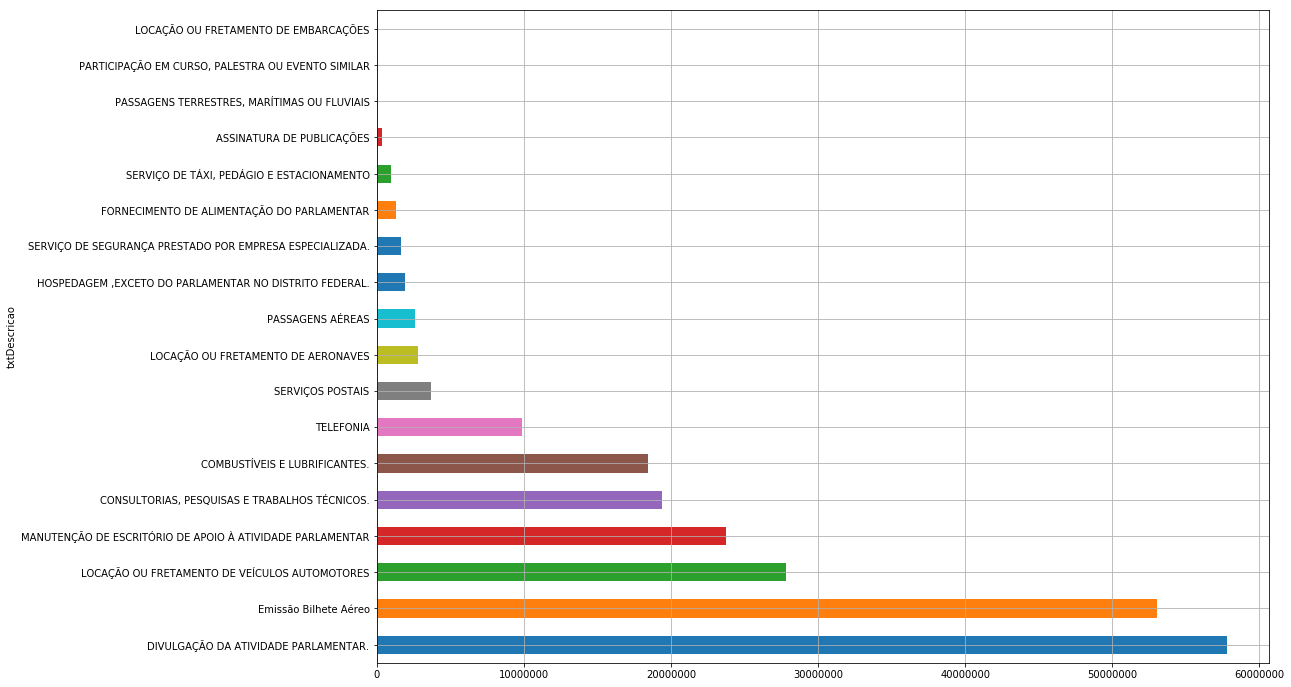

In [72]:
gastos2017.groupby(
    by=['txtDescricao'])['vlrLiquido'].sum().sort_values(ascending=False).plot(kind = 'barh',figsize=(16,12)).get_xaxis().get_major_formatter().set_scientific(False)
plt.grid()
plt.show()

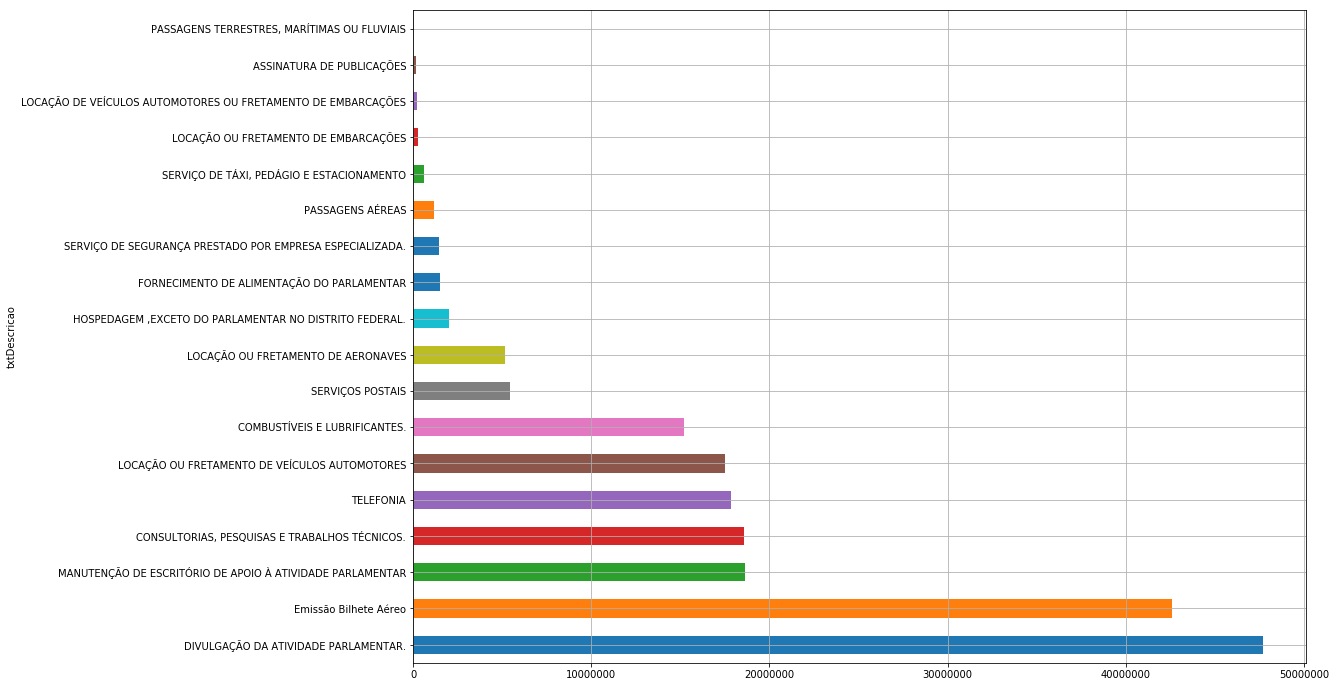

In [71]:
gastos2014.groupby(
    by=['txtDescricao'])['vlrLiquido'].sum().sort_values(ascending=False).plot(kind = 'barh',figsize=(16,12)).get_xaxis().get_major_formatter().set_scientific(False)
plt.grid()
plt.show()

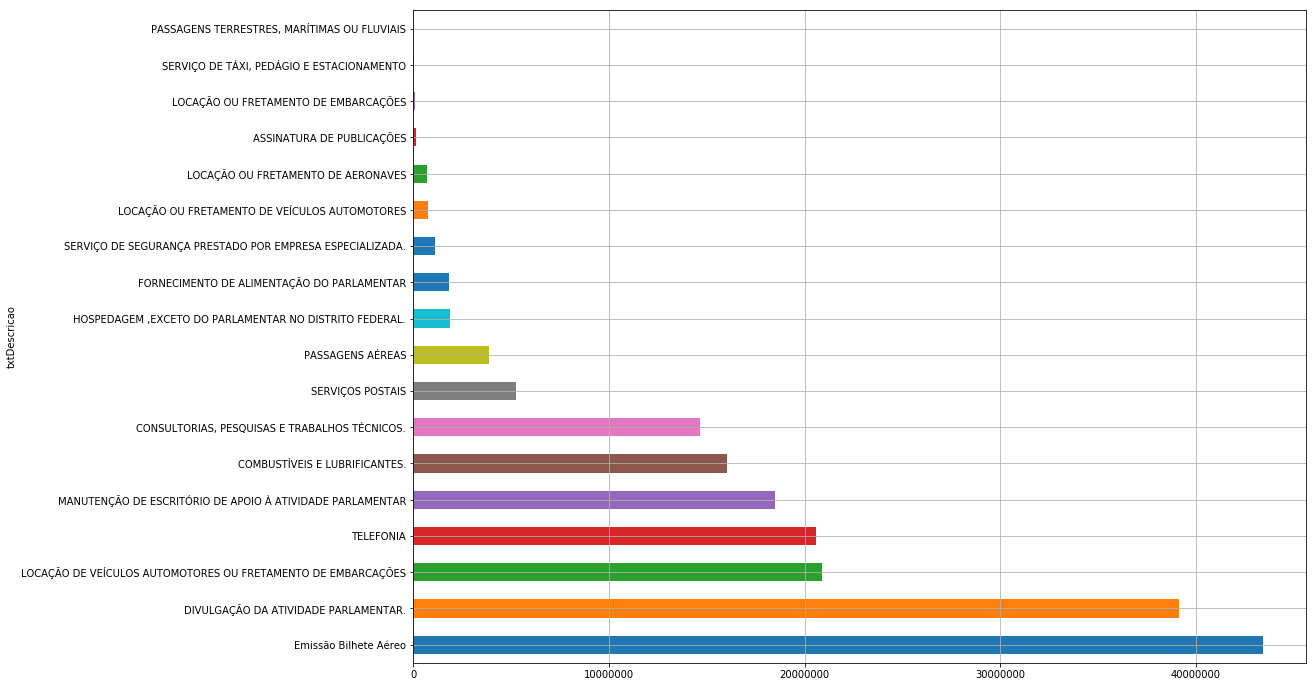

In [73]:
gastos2013.groupby(
    by=['txtDescricao'])['vlrLiquido'].sum().sort_values(ascending=False).plot(kind = 'barh',figsize=(16,12)).get_xaxis().get_major_formatter().set_scientific(False)
plt.grid()
plt.show()

In [14]:
gastos2017.groupby(
    by=['txtDescricao'])['vlrLiquido'].sum().sort_values(ascending=False).head(10)

txtDescricao
DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.                        57794360.6400
Emissão Bilhete Aéreo                                       53012103.4600
LOCAÇÃO OU FRETAMENTO DE VEÍCULOS AUTOMOTORES               27838888.5200
MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE PARLAMENTAR   23730710.9000
CONSULTORIAS, PESQUISAS E TRABALHOS TÉCNICOS.               19384379.3000
COMBUSTÍVEIS E LUBRIFICANTES.                               18451497.8200
TELEFONIA                                                    9911318.5900
SERVIÇOS POSTAIS                                             3672073.7000
LOCAÇÃO OU FRETAMENTO DE AERONAVES                           2842802.4600
PASSAGENS AÉREAS                                             2607145.2700
Name: vlrLiquido, dtype: float64

In [19]:
gastos2014.groupby(
    by=['txtDescricao'])['vlrLiquido'].sum().sort_values(ascending=False).head(10)

txtDescricao
DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.                        47736277.8000
Emissão Bilhete Aéreo                                       42584699.8100
MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE PARLAMENTAR   18619226.4600
CONSULTORIAS, PESQUISAS E TRABALHOS TÉCNICOS.               18561520.9000
TELEFONIA                                                   17855578.2500
LOCAÇÃO OU FRETAMENTO DE VEÍCULOS AUTOMOTORES               17511423.8100
COMBUSTÍVEIS E LUBRIFICANTES.                               15202206.1400
SERVIÇOS POSTAIS                                             5421584.5400
LOCAÇÃO OU FRETAMENTO DE AERONAVES                           5176484.2100
HOSPEDAGEM ,EXCETO DO PARLAMENTAR NO DISTRITO FEDERAL.       1999067.5800
Name: vlrLiquido, dtype: float64

In [18]:
gastos2013.groupby(
    by=['txtDescricao'])['vlrLiquido'].sum().sort_values(ascending=False).head(10)

txtDescricao
Emissão Bilhete Aéreo                                          43455624.3500
DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.                           39142365.7800
LOCAÇÃO DE VEÍCULOS AUTOMOTORES OU FRETAMENTO DE EMBARCAÇÕES   20900117.8400
TELEFONIA                                                      20589352.6400
MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE PARLAMENTAR      18468222.5200
COMBUSTÍVEIS E LUBRIFICANTES.                                  16054133.7200
CONSULTORIAS, PESQUISAS E TRABALHOS TÉCNICOS.                  14664455.1900
SERVIÇOS POSTAIS                                                5254806.1900
PASSAGENS AÉREAS                                                3883276.7100
HOSPEDAGEM ,EXCETO DO PARLAMENTAR NO DISTRITO FEDERAL.          1865748.2700
Name: vlrLiquido, dtype: float64

# Análise de Preposições

## Análises de Proposições por Deputado

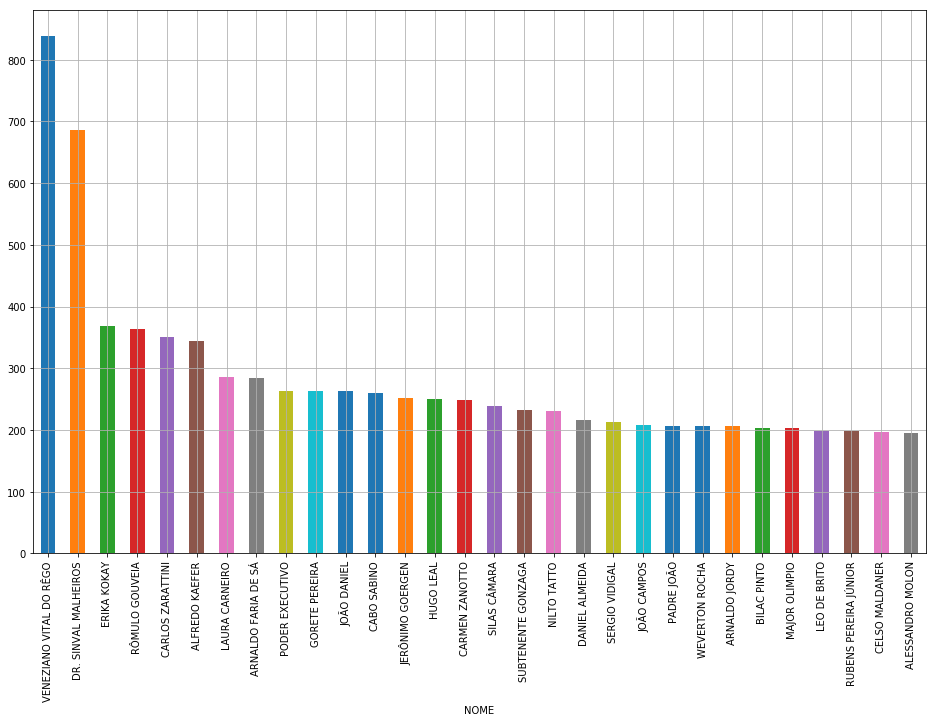

In [26]:
proposicoesautor2017.groupby(
    by=['NOME'])['PROPOSIÇÕES'].sum().sort_values(ascending=False).head(30).plot(kind='bar', figsize=(16,10), grid = True)


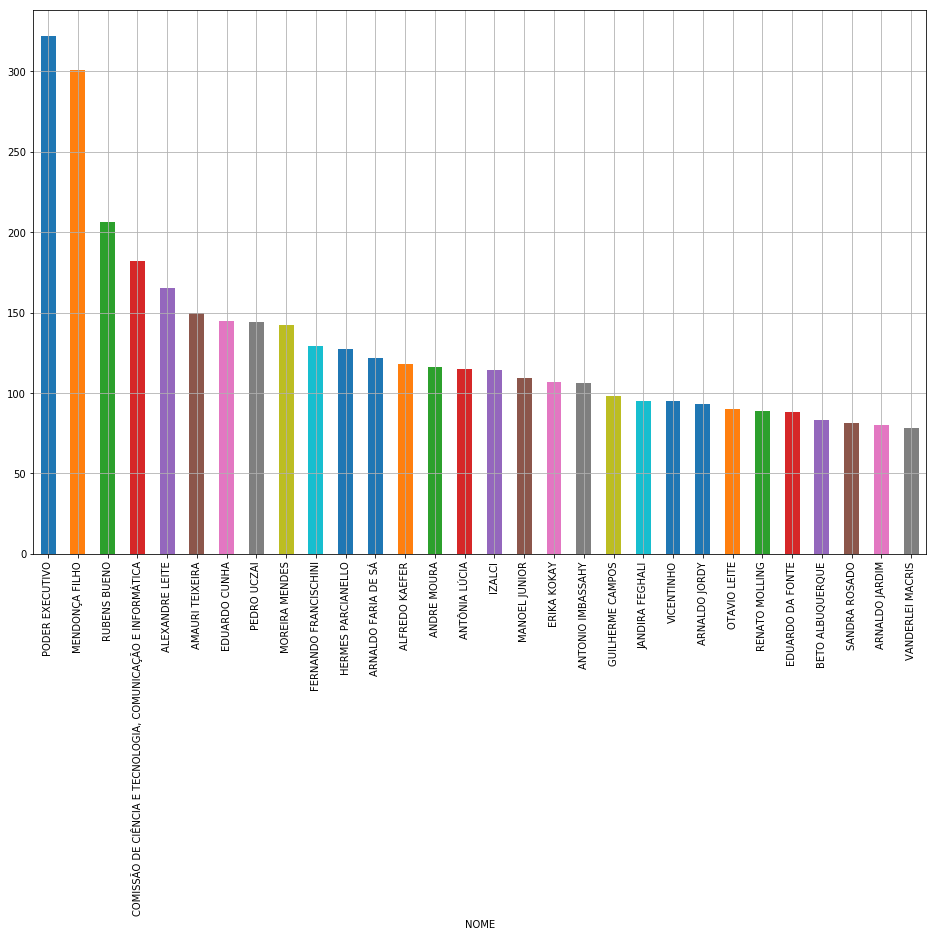

In [27]:
proposicoesautor2014.groupby(
    by=['NOME'])['PROPOSIÇÕES'].sum().sort_values(ascending=False).head(30).plot(kind='bar', figsize=(16,10), grid = True)

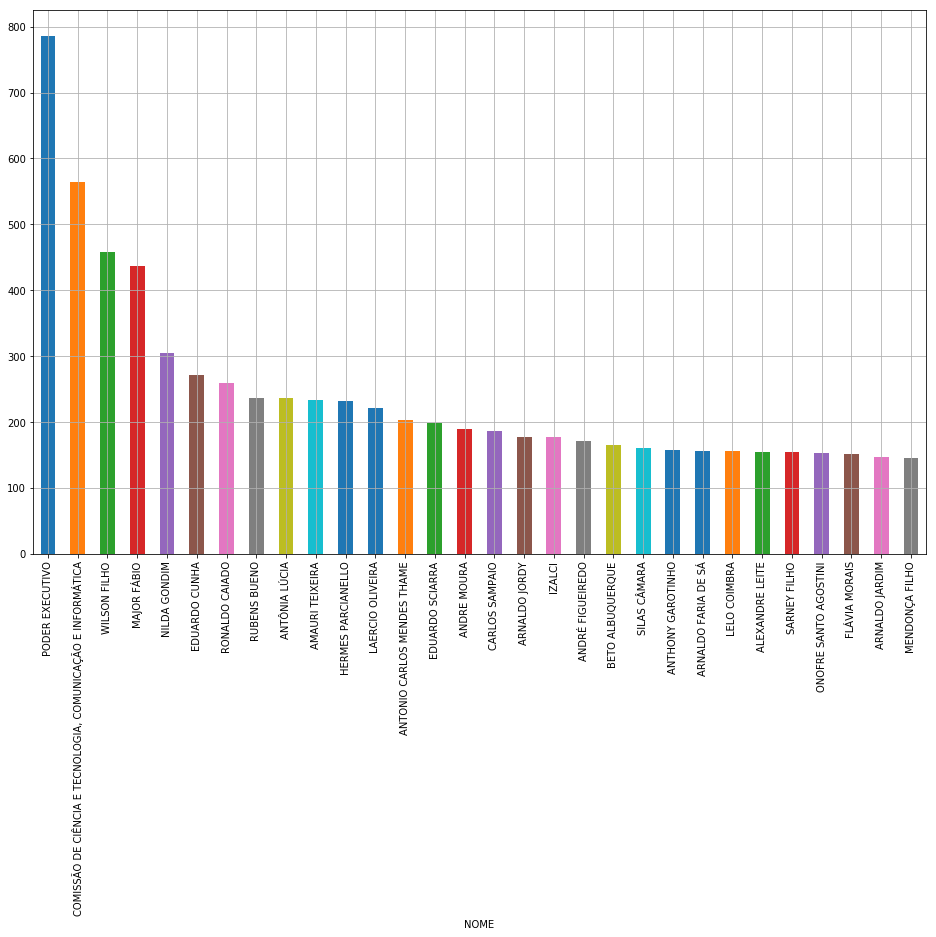

In [28]:
proposicoesautor2013.groupby(
    by=['NOME'])['PROPOSIÇÕES'].sum().sort_values(ascending=False).head(30).plot(kind='bar', figsize=(16,10), grid = True)

## Gasto por proposição

In [29]:
calcularMediaProposicao(gastos2017,proposicoes2017)

4529.24 reais por proposição na câmara dos deputados


In [30]:
calcularMediaProposicao(gastos2014,proposicoes2014)

14053.56 reais por proposição na câmara dos deputados


In [31]:
calcularMediaProposicao(gastos2013,proposicoes2013)

6075.33 reais por proposição na câmara dos deputados


## Deputados que mais e que menos gastam por proposição

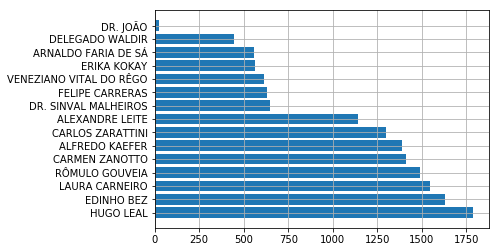

In [32]:
graficoDeputadosGastosProposicao(gastosDeputado2017, proposicoesautor2017,True)


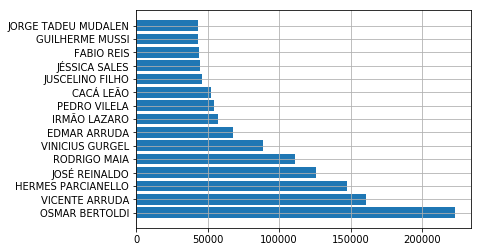

In [34]:
graficoDeputadosGastosProposicao(gastosDeputado2017, proposicoesautor2017,False)

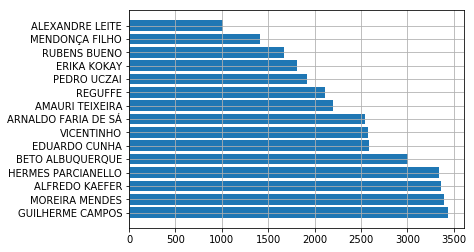

In [36]:
graficoDeputadosGastosProposicao(gastosDeputado2014, proposicoesautor2014,True)

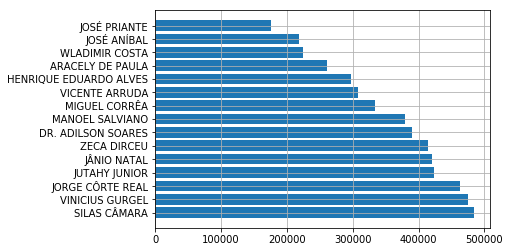

In [38]:
graficoDeputadosGastosProposicao(gastosDeputado2014, proposicoesautor2014,False)

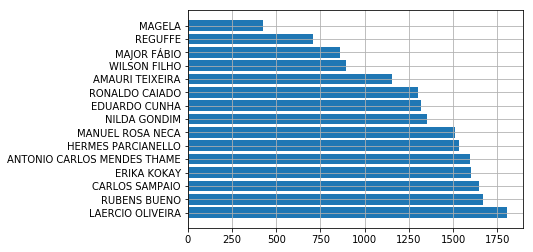

In [39]:
graficoDeputadosGastosProposicao(gastosDeputado2013, proposicoesautor2013,True)

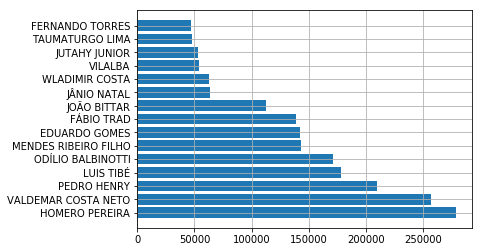

In [40]:
graficoDeputadosGastosProposicao(gastosDeputado2013, proposicoesautor2013,False)

## Análise por mês dos gastos em Divulgação da Atividade Parlamentar

### Criação de gráfico por descrição de acordo com o mês

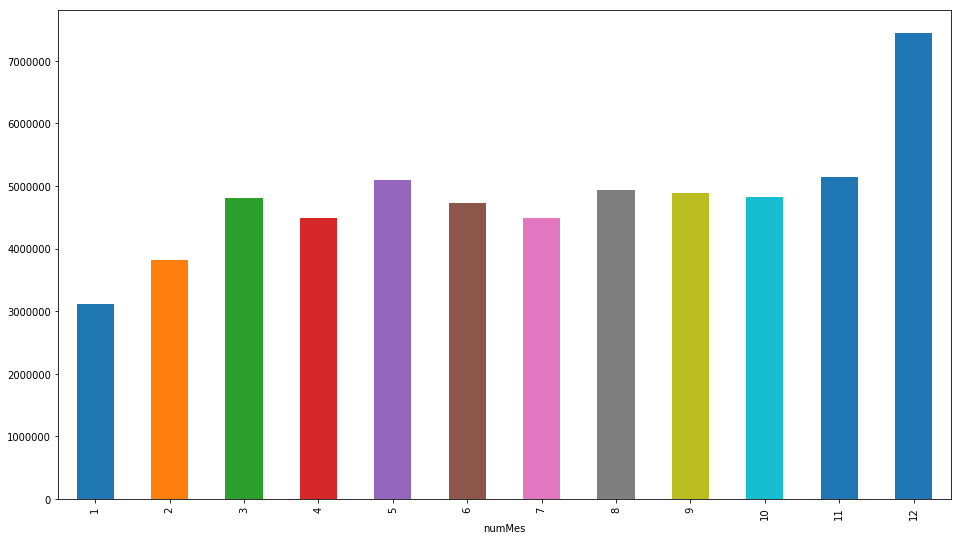

In [54]:
dfmeses2017[dfmeses2017['txtDescricao'] == 'DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.'].groupby(['numMes'])['vlrLiquido'].sum().plot(kind = 'bar',figsize=(16,9))    


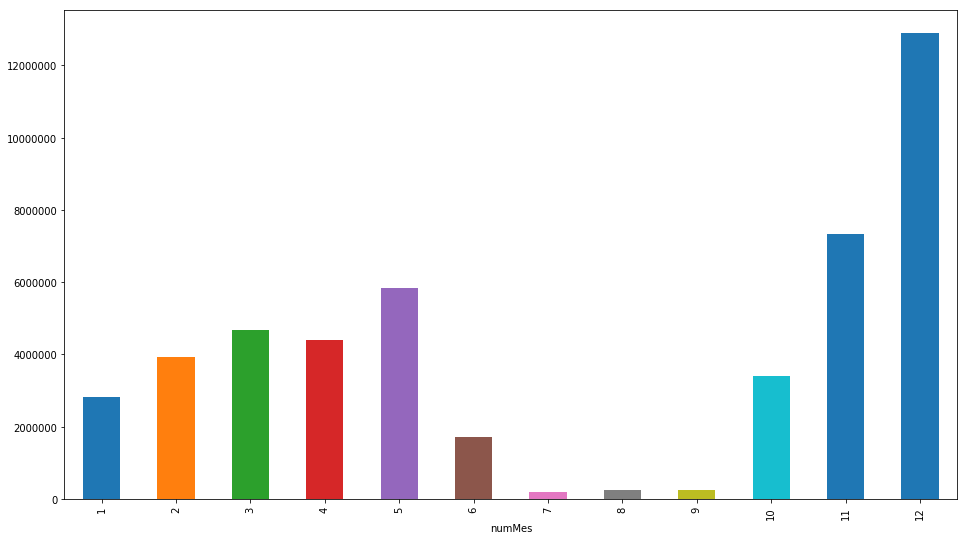

In [75]:
dfmeses2014[dfmeses2014['txtDescricao'] == 'DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.'].groupby(['numMes'])['vlrLiquido'].sum().plot(kind = 'bar',figsize=(16,9)).get_yaxis().get_major_formatter().set_scientific(False)    


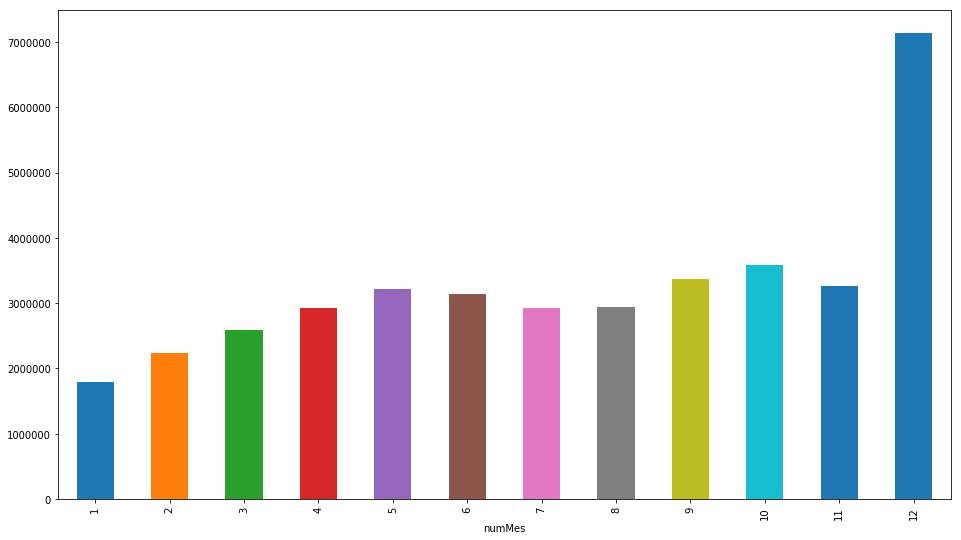

In [51]:
dfmeses2013[dfmeses2013['txtDescricao'] == 'DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.'].groupby(['numMes'])['vlrLiquido'].sum().plot(kind = 'bar',figsize=(16,9))    


## Gráficos de faixa de gasto por deputado nos anos de 2017,2014 e 2013

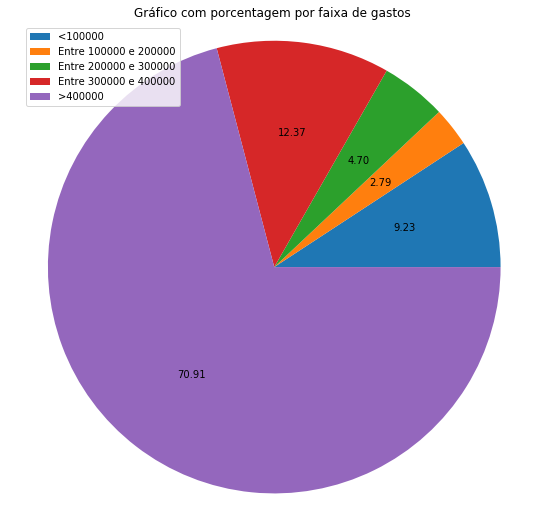

In [97]:
montarGraficoFaixadeGastos(gastosDeputado2017)

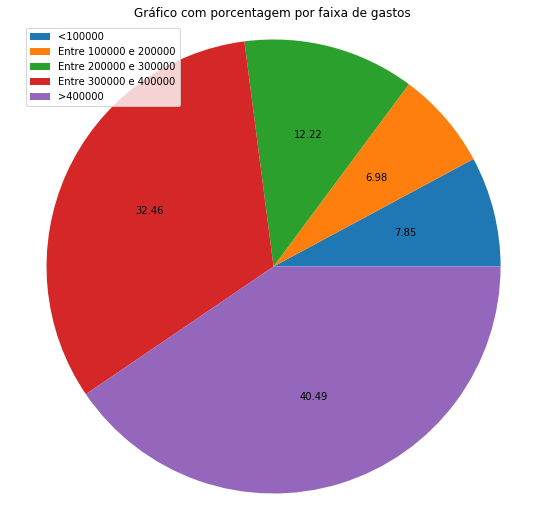

In [99]:
montarGraficoFaixadeGastos(gastosDeputado2014)

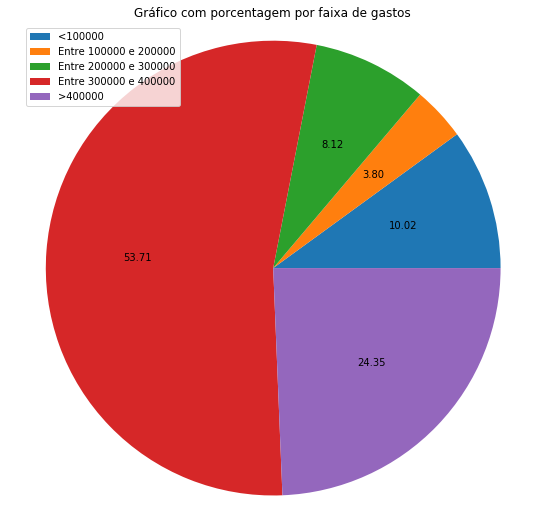

In [100]:
montarGraficoFaixadeGastos(gastosDeputado2013)